In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [2]:
predictor = TimeSeriesPredictor.load('best_predictor')

In [3]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [4]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']

In [5]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [6]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

target   ACT01  ACT03  ACT04  ACT07  ACT09  ACT13   ACT15  \
item_id timestamp                                                               
IT01    2019-12-30  7613.0  1228.0   87.0    0.0  195.0  188.0   32.0  1817.0   
        2020-01-06   390.0    87.0   63.0    0.0    5.0    8.0    0.0     0.0   
        2020-01-13   702.0   161.0   10.0    0.0   14.0    0.0   49.0     1.0   
        2020-01-20   941.0   437.0  143.0    0.0   86.0   67.0  110.0     0.0   
        2020-01-27  1470.0   403.0  457.0    0.0  178.0  108.0   48.0     7.0   

                     ACT17   ACT32  ACT44  
item_id timestamp                          
IT01    2019-12-30  1255.0  2811.0    0.0  
        2020-01-06     0.0   227.0    0.0  
        2020-01-13     0.0   467.0    0.0  
        2020-01-20     0.0    98.0    0.0  
        2020-01-27     0.0   269.0    0.0

In [7]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

target  ACT01  ACT03  ACT04  ACT07  ACT09  ACT13  ACT15  \
item_id timestamp                                                             
IT01    2022-05-02  4074.0  788.0   29.0    0.0  396.0   30.0  111.0  515.0   
        2022-05-09   756.0  137.0    0.0    0.0  124.0    0.0    0.0    0.0   
        2022-05-16   439.0  153.0   27.0    0.0   76.0    2.0   24.0    0.0   
        2022-05-23  2078.0  452.0   28.0    0.0  387.0   57.0  158.0  506.0   
        2022-05-30  3883.0  912.0  198.0    0.0  514.0  178.0  261.0   14.0   

                    ACT17   ACT32  ACT44  
item_id timestamp                         
IT01    2022-05-02  145.0  2060.0    0.0  
        2022-05-09    0.0   495.0    0.0  
        2022-05-16    0.0   157.0    0.0  
        2022-05-23  138.0   352.0    0.0  
        2022-05-30   10.0  1796.0    0.0

In [8]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  4574.191895  3452.977539  3567.475098  4027.618408   
        2022-05-09  1313.863647   531.477905  1011.096497  1202.044800   
        2022-05-16   945.418762   149.970139   593.156250   717.791565   
        2022-05-23  1202.445801   621.903015  1003.448181  1026.328613   
        2022-05-30  3623.275391  2727.274170  2926.253418  3162.873535   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  4390.746582  4574.191895  4492.978027  4863.294922   
        2022-05-09  1239.941528  1313.863647  1356.608154  1475.031982   
        2022-05-16   804.043884   945.418762  1099.279785  1232.146484   
        2022-05-23  1154.482544  1202.445801  1197.594482  1273.981079   
        2022-05-30  3448.818604  3623.275391  3506.741699  3776.715332   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4964.065430  5373.928711  
        2022-05-09  1684.295166  2012.690796  
        2022-05-16  1342.879150  1711.449097  
        2022-05-23  1414.946533  1618.803711  
        2022-05-30  3773.066406  3813.941895

In [9]:
predictor.leaderboard(test_data)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,NPTS,-0.291218,-0.872810,4.163424,0.038300,0.247416,3
1,DirectTabular,-0.379798,-0.819791,0.153631,0.133528,5.252631,8
2,PatchTST,-0.390760,-0.853419,0.117718,0.029660,274.596578,11
3,DeepAR,-0.444670,-0.945398,0.180793,0.109786,430.833620,9
4,WeightedEnsemble,-0.537652,-0.568749,18.201284,0.050815,13.494215,12
5,TemporalFusionTransformer,-0.544469,-0.568932,0.160440,0.029124,552.889732,10
6,CrostonSBA,-0.836662,-0.905811,18.037336,0.021691,35.869674,2
7,DynamicOptimizedTheta,-0.843813,-0.913061,42.235638,0.241461,50.108401,5
8,AutoETS,-1.245019,-1.040939,35.570082,0.020813,77.332164,4
9,AutoARIMA,-1.490722,-1.239598,24.156501,0.252419,72.727335,6


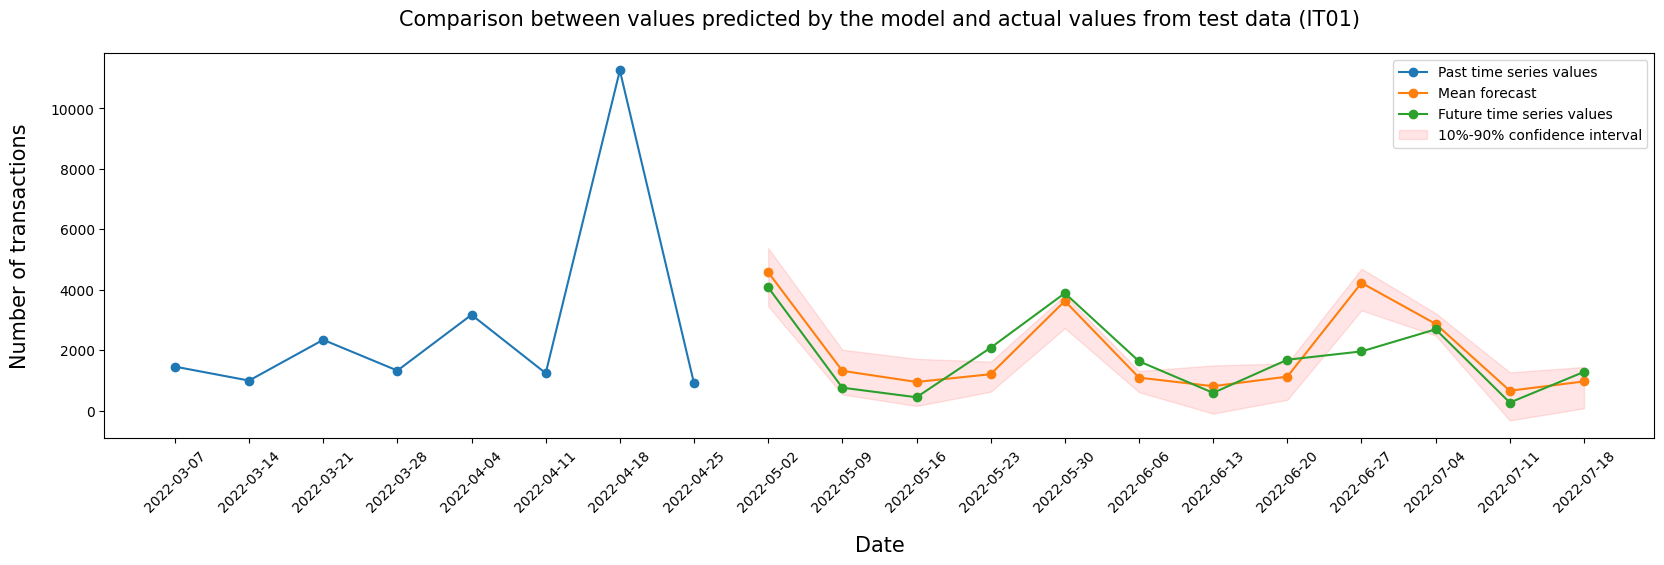

In [10]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data (IT01)", pad=20, fontsize=15)

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')

# Set the x-axis range for fill_between
fill_ticks = range(8, len(y_pred.index) + 8)

plt.fill_between(
    fill_ticks, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)

# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

In [11]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

23382.555

In [12]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [13]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02     500.191895
2022-05-09     557.863647
2022-05-16     506.418762
2022-05-23    -875.554199
2022-05-30    -259.724609
2022-06-06    -541.409790
2022-06-13     219.834961
2022-06-20    -558.968872
2022-06-27    2267.761230
2022-07-04     179.771973
2022-07-11     391.565186
2022-07-18    -316.195007
dtype: float64

In [14]:
predictor.model_names()

['SeasonalNaive',
 'CrostonSBA',
 'NPTS',
 'AutoETS',
 'DynamicOptimizedTheta',
 'AutoARIMA',
 'RecursiveTabular',
 'DirectTabular',
 'DeepAR',
 'TemporalFusionTransformer',
 'PatchTST',
 'WeightedEnsemble']